In [172]:
#Асанов Ильяс
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

In [173]:
context_size = 3
embed_size = 2
xmax = 2
alpha = 0.75
batch_size = 20
l_rate = 0.001
num_epochs = 10

In [174]:
corpus = [
    "Dexter is an American television crime drama mystery series that aired on Showtime from October 1, 2006, to September 22, 2013.[1] Set in Miami, the series centers on Dexter Morgan (Michael C. Hall), a forensic technician specializing in blood spatter pattern analysis for the fictional Miami Metro Police Department, who leads a secret parallel life as a vigilante serial killer, hunting down murderers who have slipped through the cracks of the justice system. The show's first season was derived from the novel Darkly Dreaming Dexter (2004), the first in a series of novels by Jeff Lindsay. It was adapted for television by screenwriter James Manos Jr., who wrote the first episode. Subsequent seasons evolved independently of Lindsay's works."
    "In February 2008, reruns (edited down to a TV-14 rating) began to air on CBS in the wake of the shortage of original programming ensuing from the 2007–2008 Writers Guild of America strike, thus the reruns on CBS ended after one run of the first season. The series enjoyed mostly positive reviews throughout its run and popularity. The first four seasons have received universal acclaim, although reception dropped drastically as the series progressed. The show has also won many awards, including two Golden Globe awards won by Michael C. Hall and John Lithgow for their roles as Dexter Morgan and Arthur Mitchell, respectively. Season four aired its season finale on December 13, 2009, to a record-breaking audience of 2.6 million viewers, making it the most-watched original series episode ever on Showtime at that time."
]

In [175]:
#делит корпус с предложениями на токены слов
tokens = []
for i in range(len(corpus)):
    sents = corpus[i].split(".")
    for j in range(len(sents)):
        tokens = tokens +sents[j].lower().split(" ")

In [176]:
#словарь удаляет повторяющиеся слова, но нарушает порядок
my_dict = list(set(tokens))

In [177]:
#восстановливает порядок с помощью присваивания индексов в соответствии с номером
word2idx={}
idx2word={}
for ind,token in enumerate(my_dict):
    word2idx[token]=ind
    idx2word[ind]=token

In [178]:
#создаёт словарь совстречаемости слов
ss=len(my_dict)
#создаёт матрицу из нулей квадратной размерности словаря
zero_matrix=np.zeros((ss,ss))
#прибавляет 1 в случае "встречи" слов
for idx in range (len(tokens)-1):
    ind1 = word2idx[tokens[idx]]
    ind2 = word2idx[tokens[idx+1]]
    #print(tokens[idx],tokens[idx+1])
    zero_matrix[ind1,ind2]+=1

In [179]:
#транспонирует матрицу совстречаемости и выбирает не нулевые элементы
coocs = np.transpose(np.nonzero(zero_matrix))

In [180]:
#функция выцисления нового "веса"
def wf(x):
    if x < xmax:
        return (x/xmax)**alpha
    return 1

In [181]:
#вычисление размеров словаря(без дубликатов) и колличества исходных слов
vocab_size=len(my_dict)
w_list_size=len(tokens)

#настройка векторов и biases
l_embed, r_embed = [
    [Variable(torch.from_numpy(np.random.normal(0, 0.01, (embed_size, 1))),
        requires_grad = True) for j in range(vocab_size)] for i in range(2)]
l_biases, r_biases = [
    [Variable(torch.from_numpy(np.random.normal(0, 0.01, 1)), 
        requires_grad = True) for j in range(vocab_size)] for i in range(2)]
optimizer = optim.Adam(l_embed + r_embed + l_biases + r_biases, lr = l_rate)

In [182]:
# преобразование векторов
def gen_batch():
    sample = np.random.choice(np.arange(len(coocs)), size=batch_size, replace=False)
    l_vecs, r_vecs, covals, l_v_bias, r_v_bias = [], [], [], [], []
    for chosen in sample:
        ind = tuple(coocs[chosen])
        l_vecs.append(l_embed[ind[0]])
        r_vecs.append(r_embed[ind[1]])
        covals.append(zero_matrix[ind])
        l_v_bias.append(l_biases[ind[0]])
        r_v_bias.append(r_biases[ind[1]])
    return l_vecs, r_vecs, covals, l_v_bias, r_v_bias

In [183]:
# обучение
for epoch in range(num_epochs):
    num_batches = int(w_list_size/batch_size)
    avg_loss = 0.0
    for batch in range(num_batches):
        optimizer.zero_grad()
        l_vecs, r_vecs, covals, l_v_bias, r_v_bias = gen_batch()
        loss = sum([torch.mul((torch.dot(l_vecs[i].view(-1), r_vecs[i].view(-1)) +
                l_v_bias[i] + r_v_bias[i] - np.log(covals[i]))**2,
                wf(covals[i])) for i in range(batch_size)])
        avg_loss += loss.data[0]/num_batches
        loss.backward()
        optimizer.step()
    print("Average loss for epoch "+str(epoch+1)+": ", avg_loss)

Average loss for epoch 1:  tensor(0.8308, dtype=torch.float64)
Average loss for epoch 2:  tensor(1.2964, dtype=torch.float64)
Average loss for epoch 3:  tensor(0.4417, dtype=torch.float64)
Average loss for epoch 4:  tensor(0.9234, dtype=torch.float64)
Average loss for epoch 5:  tensor(0.8378, dtype=torch.float64)
Average loss for epoch 6:  tensor(0.5850, dtype=torch.float64)
Average loss for epoch 7:  tensor(1.0978, dtype=torch.float64)
Average loss for epoch 8:  tensor(0.6957, dtype=torch.float64)
Average loss for epoch 9:  tensor(0.8050, dtype=torch.float64)
Average loss for epoch 10:  tensor(0.8060, dtype=torch.float64)


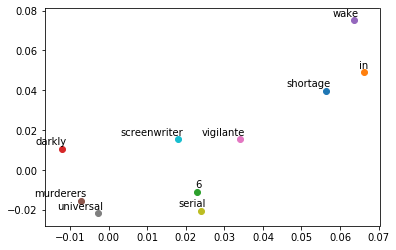

In [184]:
# Визуализация
%matplotlib inline
if embed_size == 2:
    #выбирает случайные слова для визуализации
    word_inds = np.random.choice(np.arange(len(my_dict)), size=10, replace=False)
    for word_ind in word_inds:
        # складывает вектора правого и левого слова
        w_embed = (l_embed[word_ind].data + r_embed[word_ind].data).numpy()
        x, y = w_embed[0][0], w_embed[1][0]
        plt.scatter(x, y)
        plt.annotate(my_dict[word_ind], xy=(x, y), xytext=(5, 2),
            textcoords='offset points', ha='right', va='bottom')
    plt.show()